In [50]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class HashFamily():
    """Universal hash family
    Args:
        bins (int): Number of bins to hash to. Better if a prime number.
        moduler (int,optional): Temporary hashing. Has to be a prime number.
    """
    def __init__(self, bins, moduler=None):
        if moduler and moduler <= bins:
            raise ValueError("p (moduler) should be >> m (buckets)")

        self.bins = bins
        self.moduler = moduler if moduler else self._next_prime(np.random.randint(self.bins + 1, 2**32))

        # do not allow same a and b, as it could mean shifted hashes
        self.sampled_a = set()
        self.sampled_b = set()

    def _is_prime(self, x):
        """Naive is prime test."""
        for i in range(2, int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True

    def _next_prime(self, n):
        """Naively gets the next prime larger than n."""
        while not self._is_prime(n):
            n += 1

        return n

    def draw_hash(self, a=None, b=None):
        """Draws a single hash function from the family."""
        if a is None:
            while a is None or a in self.sampled_a:
                a = np.random.randint(1, self.moduler - 1)
                assert len(self.sampled_a) < self.moduler - 2, "please give a bigger moduler"

            self.sampled_a.add(a)
        if b is None:
            while b is None or b in self.sampled_b:
                b = np.random.randint(0, self.moduler - 1)
                assert len(self.sampled_b) < self.moduler - 1, "please give a bigger moduler"

            self.sampled_b.add(b)

        return lambda x: ((a * x + b) % self.moduler) % self.bins

    def draw_hashes(self, n, **kwargs):
        """Draws n hash function from the family."""
        return [self.draw_hash() for i in range(n)]

In [61]:
def power2(color):
    return 2**(color)

def dp_helper(dp_mat, cur_color, G, colors, k, s):
    for col in range(dp_mat.shape[1]):
        if bin(col).count("1")!=cur_color-1:
            continue
        for v in G.nodes():
            if dp_mat[v][col]==1:
                for neighbor in G[v]:
                    dp_mat[neighbor][power2(colors[neighbor])|col] = 1
    if cur_color==k:
        return np.where(dp_mat[:,-1]==1)[0]
    return dp_helper(dp_mat, cur_color+1, G, colors, k, s)
        

def colorful_path(G, colors, k, s):
    """Detect if colorful path exists fom s to any node by dynamic programming.
    Args:
        G (nx.Graph): with n nodes and m edges
        colors (list): list of integers represents node colors
        k (int): number of colors 
        s (int): starting node
    Return:
        List: nodes connect to s with at least one colorful path
    """
    n = G.number_of_nodes()
    col = 2**k
    dp_mat = np.zeros((n, col))
    dp_mat[s][power2(colors[s])] = 1
    return dp_helper(dp_mat, 2, G, colors, k, s)

def color_by_hashes(G, k, repeat, modulor=None):
    hashes = HashFamily(k, modulor)
    hash_list = hashes.draw_hashes(repeat)
    color_list = []
    for hashF in hash_list:
        color_list.append([hashF(i) for i in G.nodes])
    return color_list

In [47]:
# Demo for correctness
G = nx.erdos_renyi_graph(10, 0.5)

k = 3
repeat = math.ceil(math.exp(k))

colors = color_by_hashes(G, k, repeat, modulor=97)


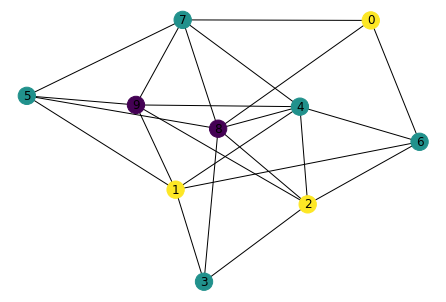

Colorful paths exist between node 0 and [3 4 5 7 8 9]


In [62]:

for color in colors:
    nx.draw(G, node_color=color, with_labels=True)
    plt.show()
    for i in G.nodes():
        tmp_res = colorful_path(G, color, k, i)
        print('Colorful paths exist between node', i, 'and', tmp_res)
        break
    break